# MissForest Imputation for ThyroidDF

## Libraries

In [1]:
# %pip install scikit-learn==1.1.2
# %pip install scipy==1.9.1
# %pip install missingpy==0.2.0

In [2]:
import numpy as np
import pandas as pd
from utils.data_split import k_fold_split
from utils.comparison_utils import compare_imputations
from utils.forgetter import forget_random_col_per_sample
from utils.plotter import plot_col_histograms, plot_col_boxplots
from utils.category_utils import transform_categorical_columns, inverse_transform_categorical_columns, get_column_indices

In [3]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [4]:
import warnings
warnings.simplefilter('ignore')

## Data cleaning and preprocessing

In [5]:
qual_cols = { "age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG" }
cat_cols = { "sick", "referral_source", "on_antithyroid_meds", "lithium", "goitre", "tumor", "thyroid_surgery", "sex", "target", "on_thyroxine", "psych", "I131_treatment", "pregnant" }

In [6]:
remove_qual_cols = { "TBG" }
remove_cat_cols = { "referral_source" }

In [7]:
sel_qual_cols = list(qual_cols.difference(remove_qual_cols))
sel_cat_cols = list(cat_cols.difference(remove_cat_cols))
display(sel_qual_cols)
display(sel_cat_cols)

['FTI', 'T3', 'TT4', 'TSH', 'T4U', 'age']

['sick',
 'I131_treatment',
 'pregnant',
 'on_thyroxine',
 'thyroid_surgery',
 'tumor',
 'lithium',
 'on_antithyroid_meds',
 'goitre',
 'psych',
 'target',
 'sex']

In [8]:
df = pd.read_csv("./data/thyroidDF.csv")
df = df[(df["age"] >= 0) & (df["age"] < 100)]
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [9]:
transformed_nan_df, label_encoders = transform_categorical_columns(df, sel_cat_cols)
transformed_nan_df = transformed_nan_df[sel_cat_cols+sel_qual_cols]
transformed_nan_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.3,NaN,29
1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,1.9,128.0,1.6,NaN,29
2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,41
3,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,36
4,0,0,0,0,0,0,0,0,0,0,31,0,NaN,NaN,NaN,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,0,0,0,0,0,0,0,0,0,0,0,1,77.0,NaN,64.0,NaN,0.83,56
9168,0,0,0,0,0,0,0,0,0,0,0,1,99.0,NaN,91.0,NaN,0.92,22
9169,0,0,0,0,0,0,0,0,0,0,16,1,89.0,NaN,113.0,NaN,1.27,69
9170,0,0,0,0,0,0,0,0,0,0,0,0,88.0,NaN,75.0,NaN,0.85,47


In [10]:
transformed_df = transformed_nan_df.dropna()
transformed_df.shape

(5981, 18)

## Train & Test split

In [11]:
k = 5

In [12]:
print(f"train: {transformed_df.shape[0] / k * (k-1)}\ntest: {transformed_df.shape[0] / k}")

train: 4784.8
test: 1196.2


In [13]:
train_df, test_df = k_fold_split(transformed_df, k)

## Select missing values

In [14]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1,
    "sick" : 1,
    "on_antithyroid_meds" : 1,
    "lithium" : 1,
    "goitre" : 1,
    "tumor" : 1,
    "thyroid_surgery" : 1,
    "sex" : 1,
    "target" : 1,
    "on_thyroxine" : 1,
    "psych" : 1,
    "I131_treatment" : 1,
    "pregnant" : 1,
    "target" : 1
}

In [15]:
seed = 1106
random_generator = np.random.default_rng(seed)

In [16]:
train_missing_vals_df, train_missing_col_map, train_missing_vals_idxs = forget_random_col_per_sample(train_df, weight_map, random_generator)
test_missing_vals_df, test_missing_col_map, test_missing_vals_idxs = forget_random_col_per_sample(test_df, weight_map, random_generator)

## MissForest Imputation

In [17]:
imputer = MissForest(missing_values=np.NaN, n_estimators=100)
X_train = train_missing_vals_df.to_numpy()
imputer = imputer.fit(X_train, cat_vars=get_column_indices(train_missing_vals_df, sel_cat_cols))
X_train_imputed = imputer.transform(X_train)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


### Results on training set

In [18]:
imputed_train_df = pd.DataFrame(X_train_imputed, columns=train_missing_vals_df.columns, index=train_missing_vals_df.index)
imputed_train_data_df = inverse_transform_categorical_columns(imputed_train_df.copy(), label_encoders)
imputed_train_data_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
3065,f,f,f,f,f,f,f,f,f,f,-,M,107.0,1.6,86.0,2.1000,0.80,55.0
4154,f,f,f,f,f,f,f,f,f,f,-,F,124.0,1.9,125.0,1.9000,1.01,63.0
1160,f,f,f,f,f,f,f,f,f,f,K,F,69.0,1.0,65.0,2.9141,0.95,86.0
4470,f,f,f,f,f,f,f,f,f,t,-,M,140.0,2.3,132.0,1.4000,0.94,27.0
1037,f,f,f,f,f,f,f,f,f,f,-,F,102.0,1.5,108.0,0.2500,1.06,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5394,f,f,f,f,f,f,f,f,f,f,-,F,90.0,1.0,77.0,1.9000,0.86,36.0
161,f,f,f,f,f,f,f,f,f,f,-,F,120.0,1.4,98.0,0.9000,0.82,72.0
5704,f,f,f,f,f,f,f,f,f,f,-,F,136.0,1.7,138.0,2.4000,1.02,43.0
2884,f,f,f,f,f,f,f,f,f,f,-,M,116.0,7.6,120.0,0.1500,1.04,60.0


In [19]:
train_results = compare_imputations(train_df, imputed_train_df, train_missing_col_map)
train_results

,Column,MSE,RMSE,MAE
0,on_thyroxine,0.088889,0.298142,0.088889
1,I131_treatment,0.010989,0.104828,0.010989
2,TSH,675.643783,25.993149,4.481020
3,on_antithyroid_meds,0.022388,0.149626,0.022388
4,tumor,0.010870,0.104257,0.010870
5,pregnant,0.026022,0.161314,0.026022
6,target,20.507353,4.528504,1.022059
7,psych,0.087121,0.295163,0.087121
8,goitre,0.007782,0.088216,0.007782
9,sick,0.034364,0.185376,0.034364


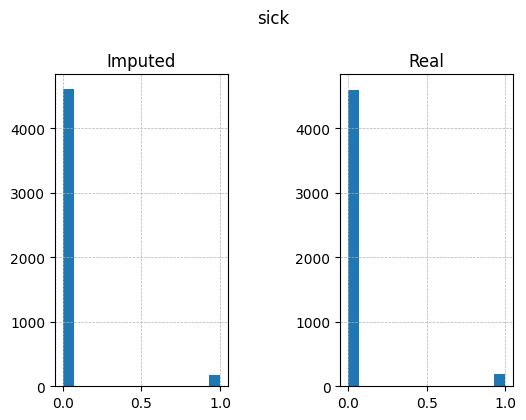

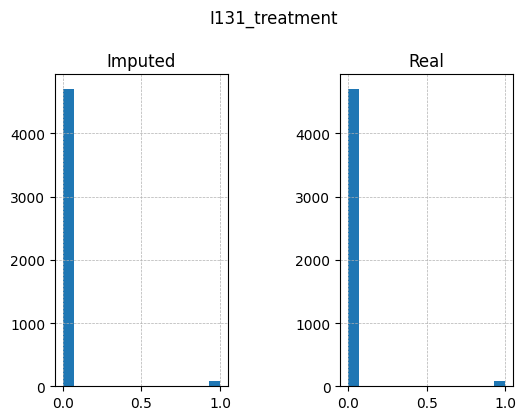

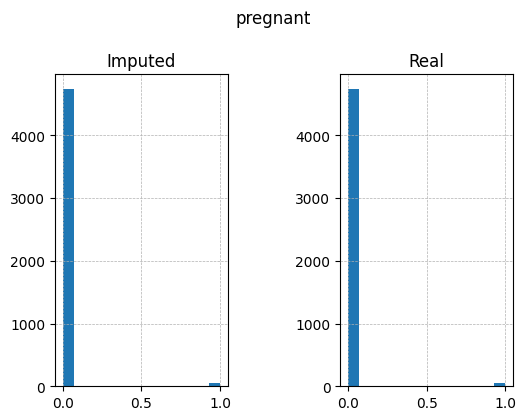

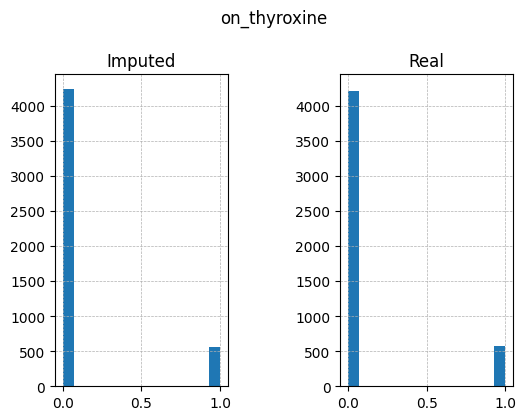

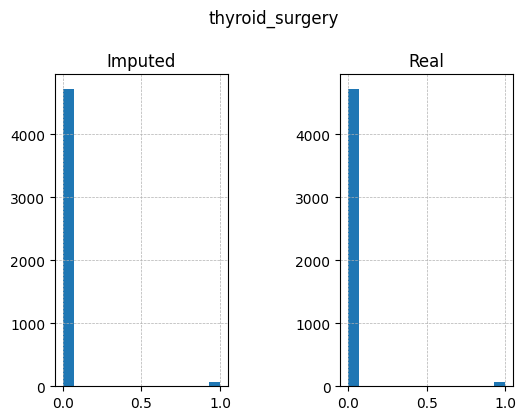

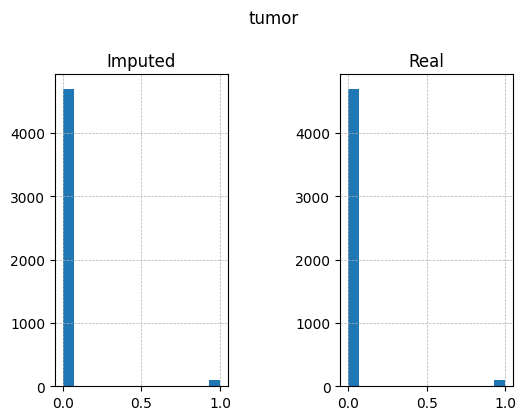

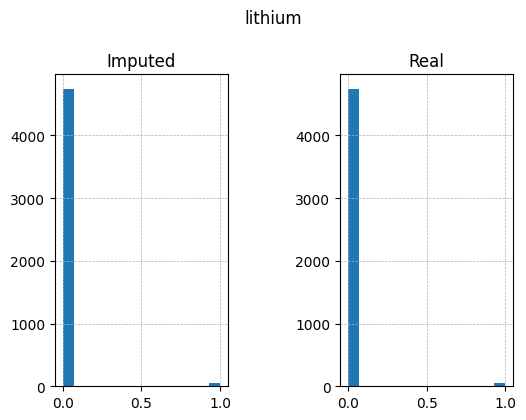

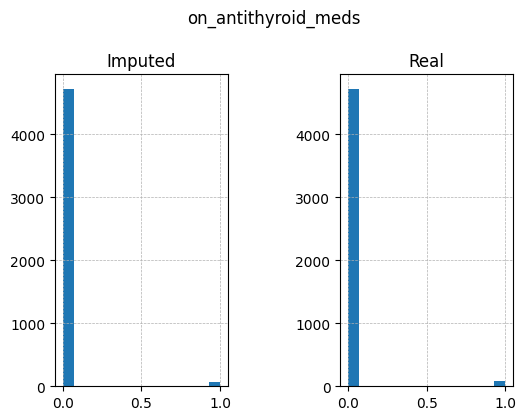

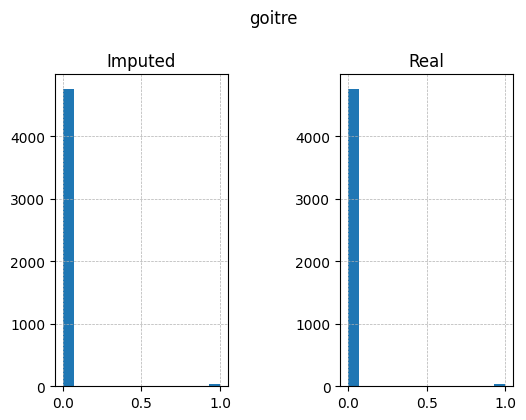

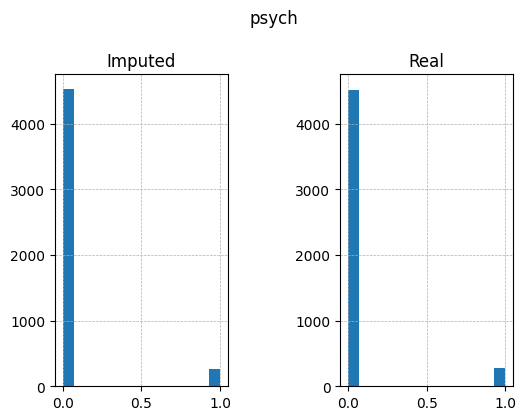

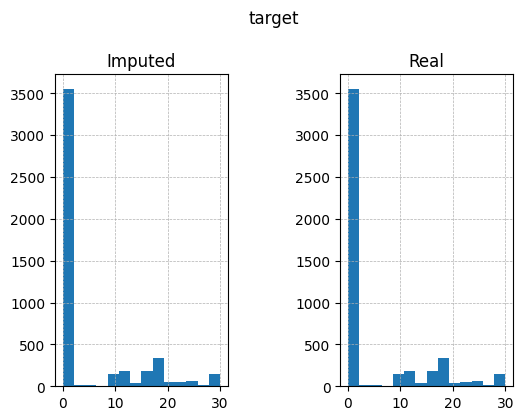

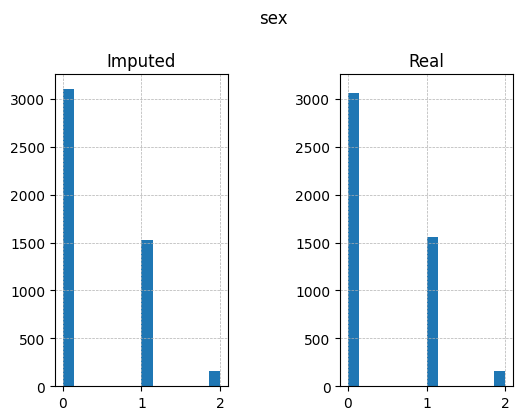

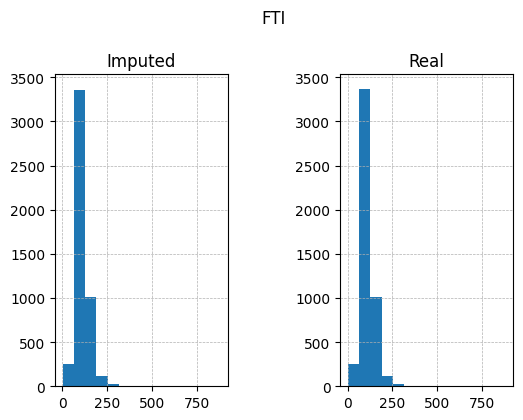

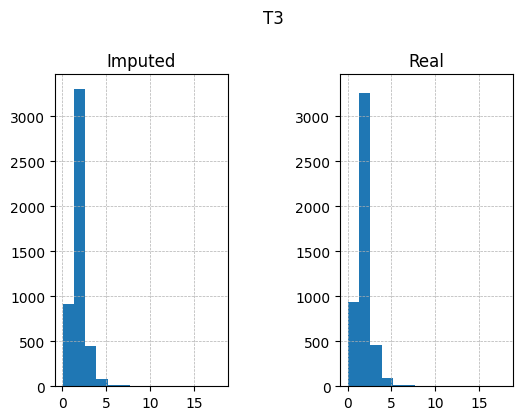

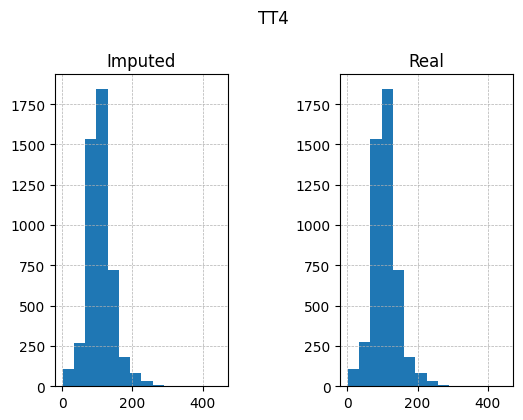

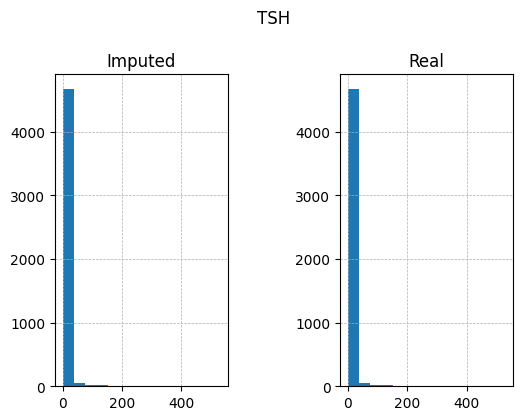

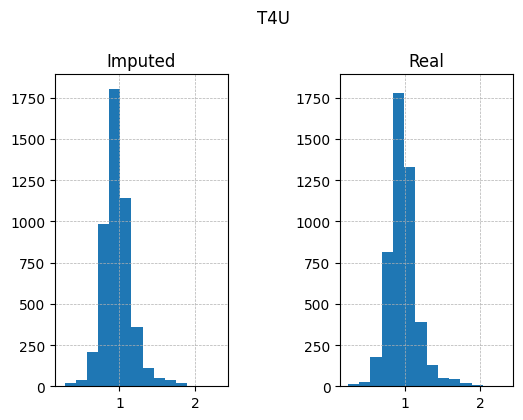

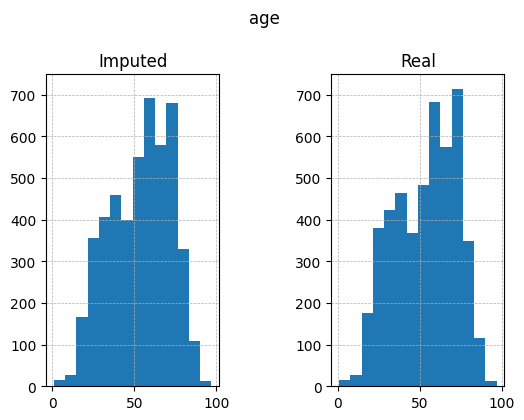

In [20]:
plot_col_histograms(train_df, imputed_train_df)

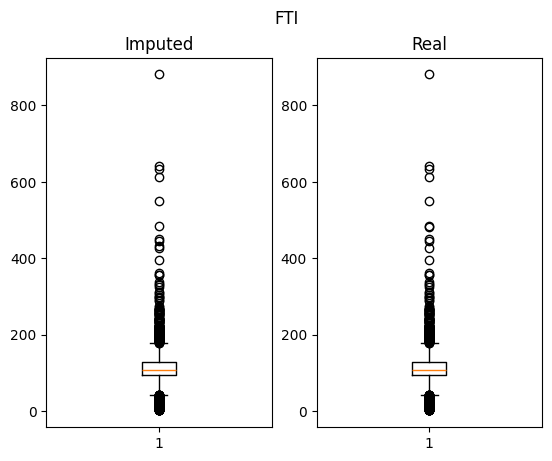

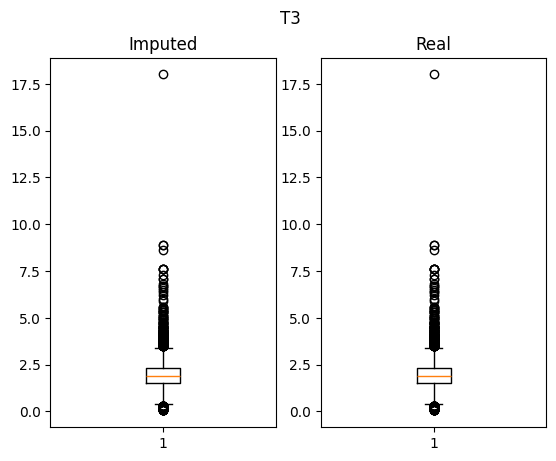

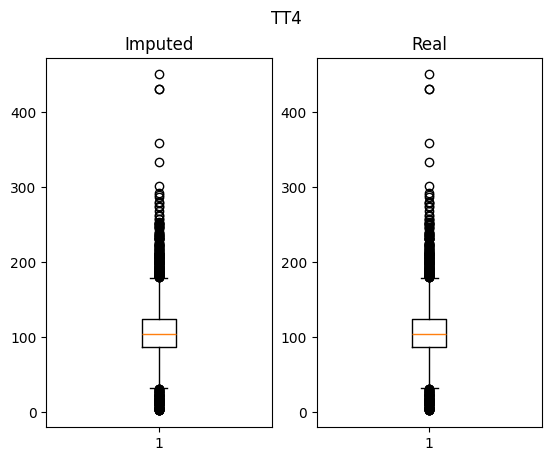

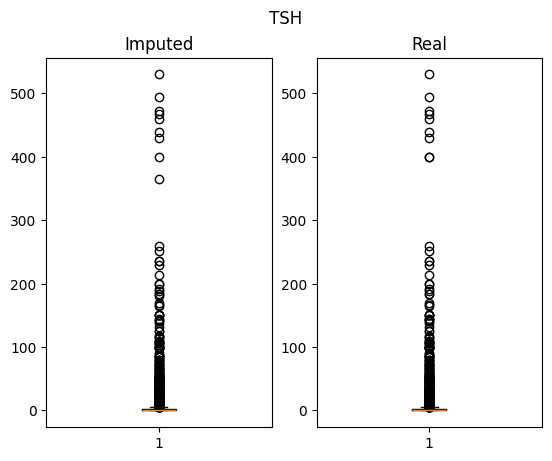

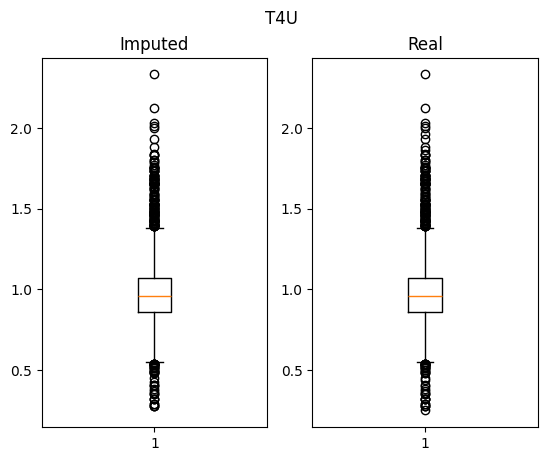

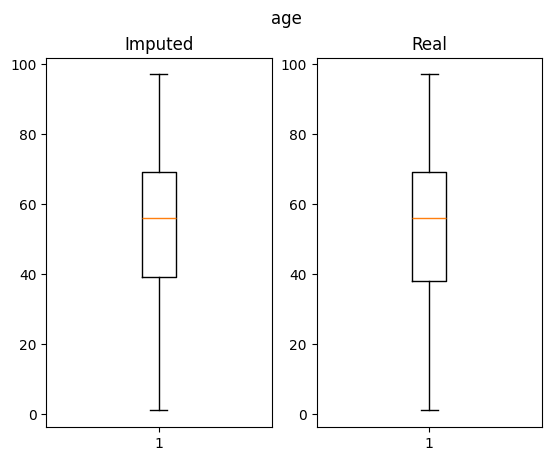

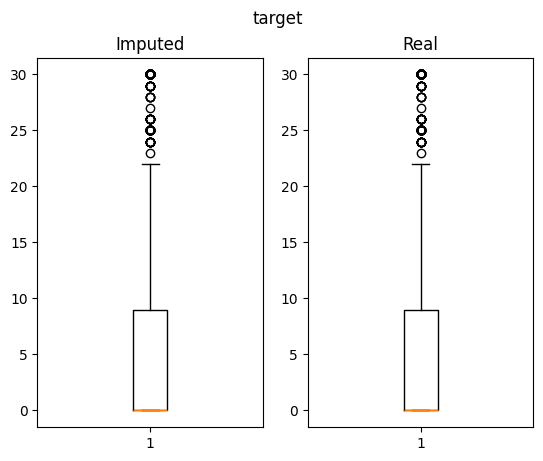

In [21]:
plot_col_boxplots(train_df[sel_qual_cols+['target']], imputed_train_df[sel_qual_cols+['target']])

In [22]:
imputed_means = np.concatenate([imputer.statistics_['col_modes'].flatten(), imputer.statistics_['col_means']])
imputed_means_df = pd.DataFrame([imputed_means], columns=sel_cat_cols+sel_qual_cols)
imputed_means_df = inverse_transform_categorical_columns(imputed_means_df, label_encoders)
imputed_means_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
0,f,f,f,f,f,f,f,f,f,f,-,F,112.877198,1.941607,107.76411,5.405715,0.974748,53.557162


### Results on test set (cross-validation)

In [23]:
X_test = test_missing_vals_df.to_numpy()
X_test_imputed = imputer.transform(X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [24]:
imputed_test_df = pd.DataFrame(X_test_imputed, columns=test_missing_vals_df.columns)
imputed_test_data_df = inverse_transform_categorical_columns(imputed_test_df.copy(), label_encoders)
imputed_test_data_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
0,f,f,f,f,f,f,f,f,f,t,-,M,113.0,1.8,122.0,1.9,0.9200,36.00
1,f,f,f,f,f,f,f,f,f,f,-,F,109.0,2.3,134.0,1.5,1.2400,28.00
2,f,f,f,f,f,f,f,f,f,f,-,F,131.0,1.0,111.0,0.5,0.8461,69.00
3,f,f,f,f,f,f,f,f,f,f,-,F,120.0,2.3,121.0,3.0,1.0100,72.00
4,f,f,f,f,f,f,f,f,t,f,-,F,80.0,2.1,82.0,1.4,1.0200,47.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,f,f,f,f,t,f,f,f,f,f,-,F,66.0,2.2,69.0,1.0,1.0400,51.16
1192,f,f,f,f,f,f,f,f,f,f,-,M,138.0,2.8,131.0,3.1,0.9500,19.00
1193,f,f,f,f,f,f,f,f,f,f,-,F,107.0,1.6,121.0,1.4,1.1300,79.00
1194,f,f,f,f,f,f,f,f,f,f,-,F,83.0,1.5,100.0,0.3,1.2000,87.00


In [25]:
test_results = compare_imputations(test_df, imputed_test_df, test_missing_col_map)
test_results

,Column,MSE,RMSE,MAE
0,on_thyroxine,0.115385,0.339683,0.115385
1,lithium,0.013333,0.115470,0.013333
2,T4U,0.004509,0.067150,0.026916
3,psych,0.049180,0.221766,0.049180
4,thyroid_surgery,0.031250,0.176777,0.031250
5,I131_treatment,0.013514,0.116248,0.013514
6,TT4,488.156600,22.094266,5.200500
7,goitre,0.025000,0.158114,0.025000
8,T3,0.288180,0.536824,0.411636
9,sick,0.083333,0.288675,0.083333


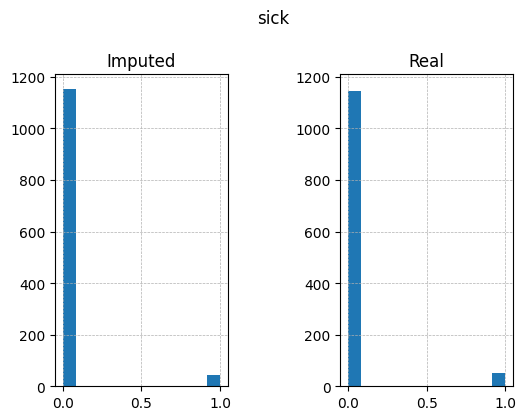

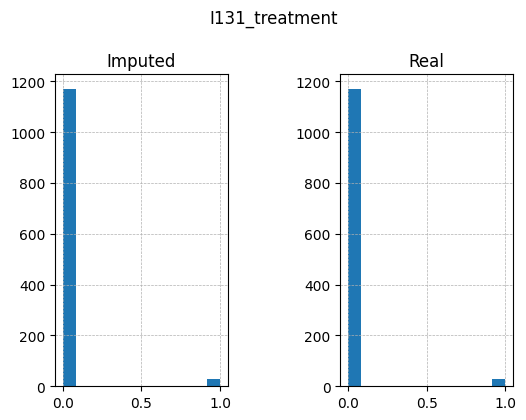

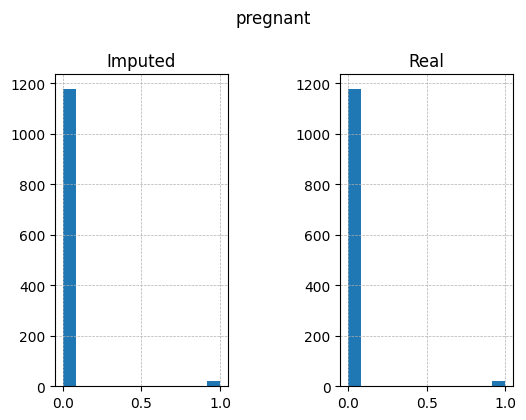

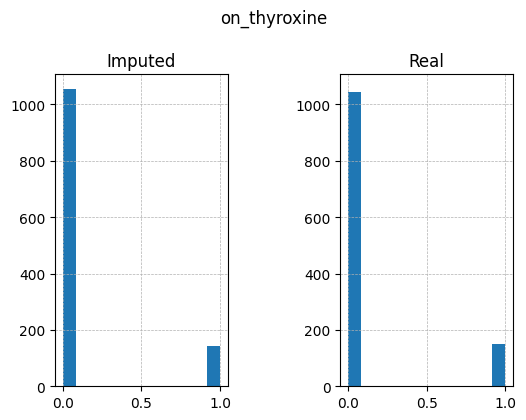

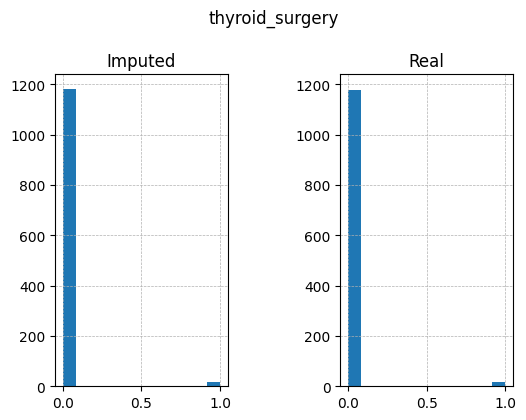

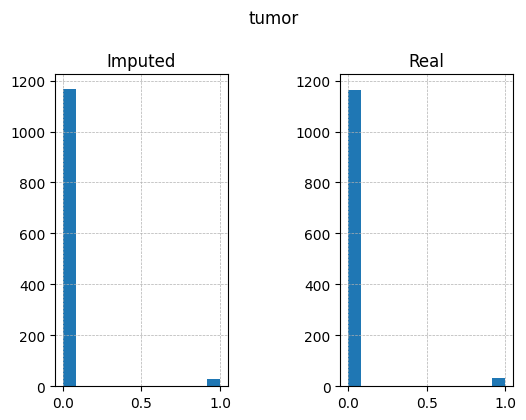

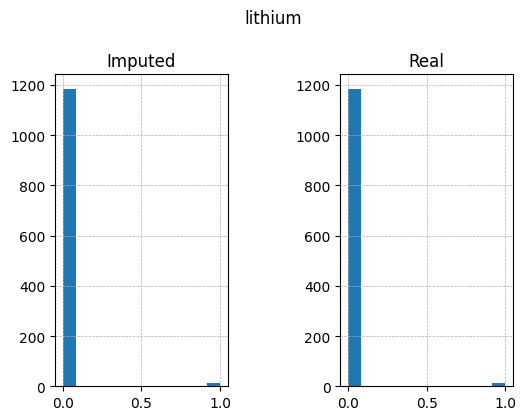

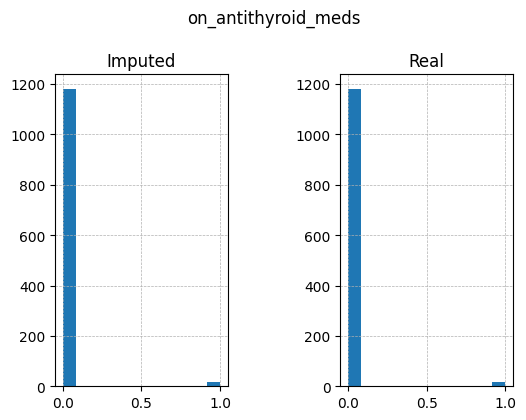

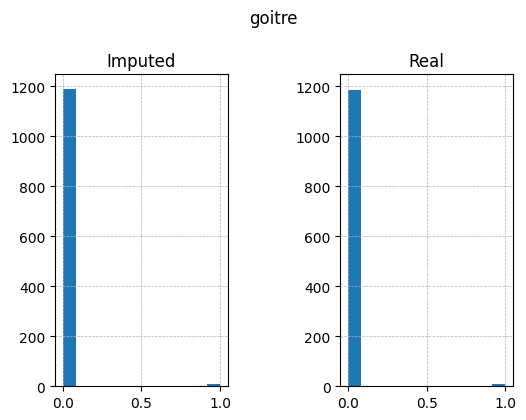

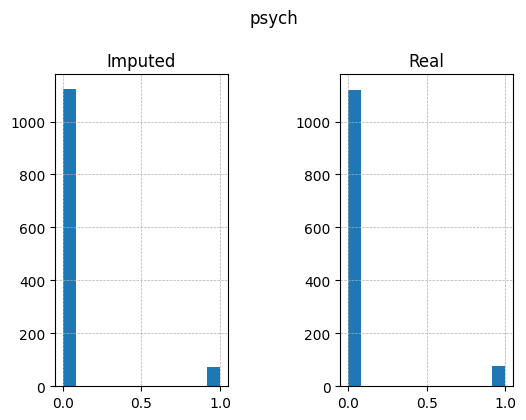

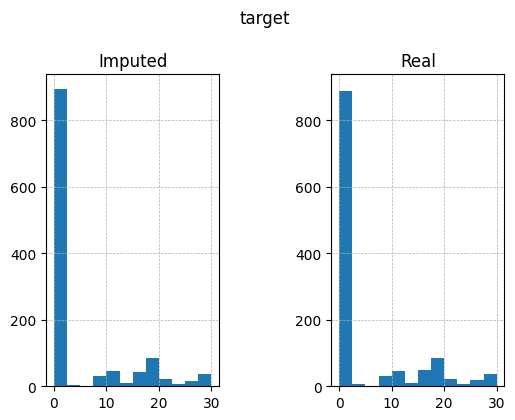

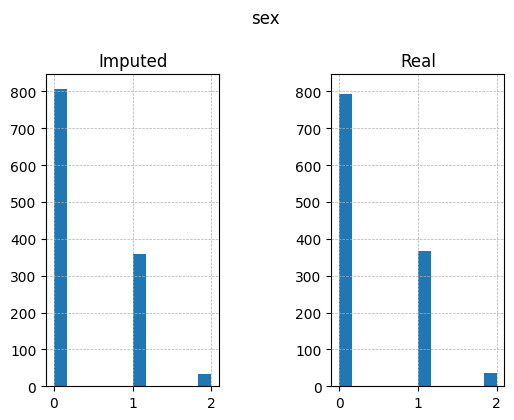

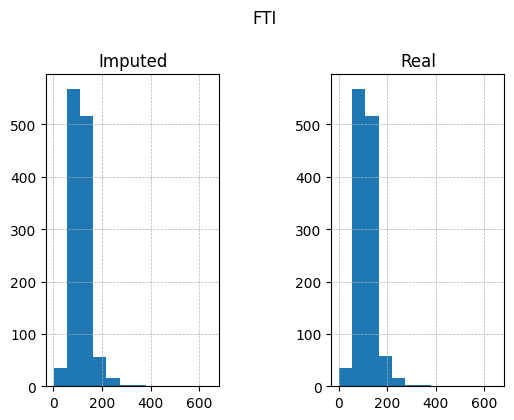

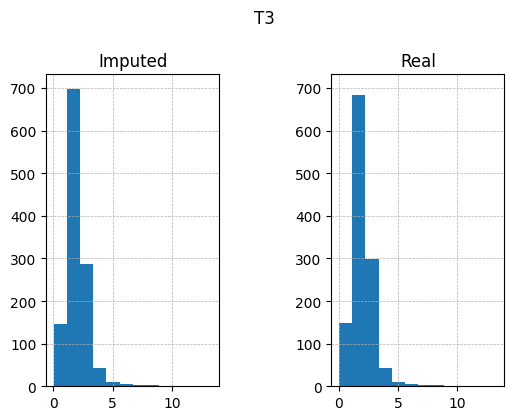

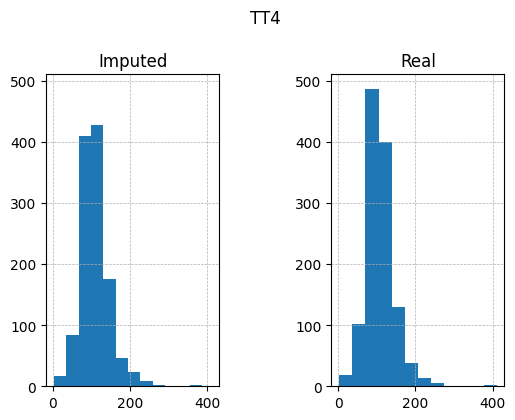

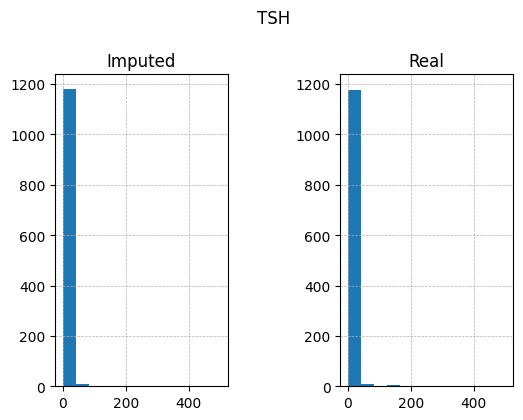

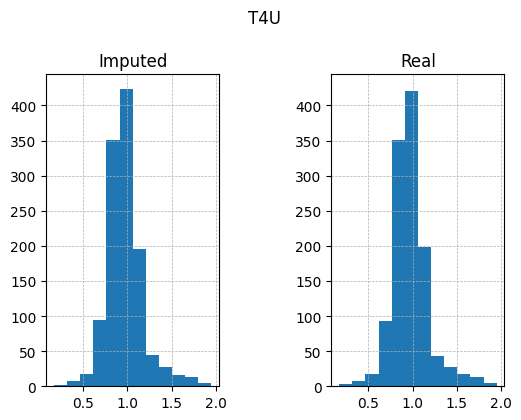

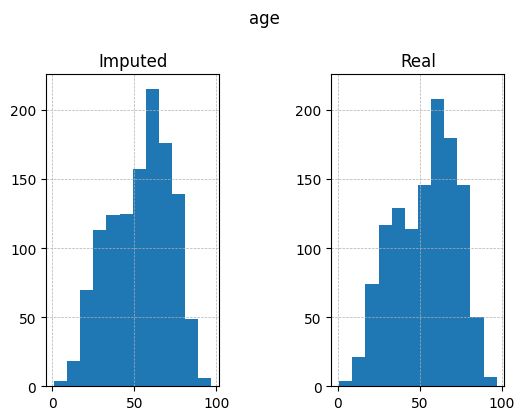

In [26]:
plot_col_histograms(test_df, imputed_test_df)

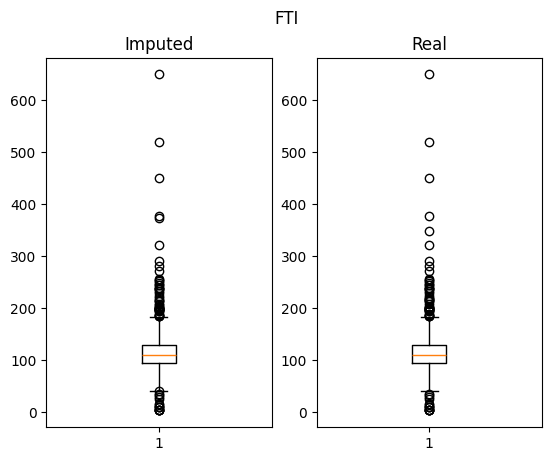

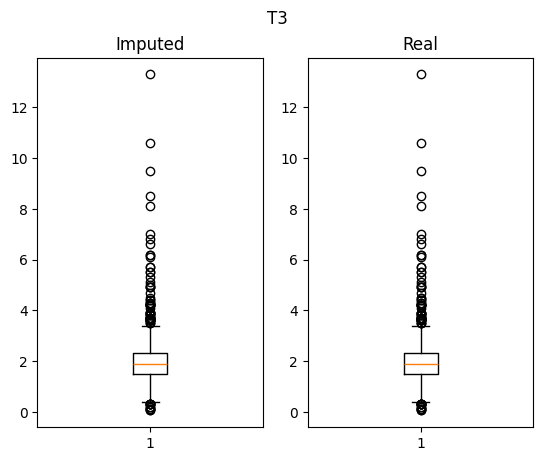

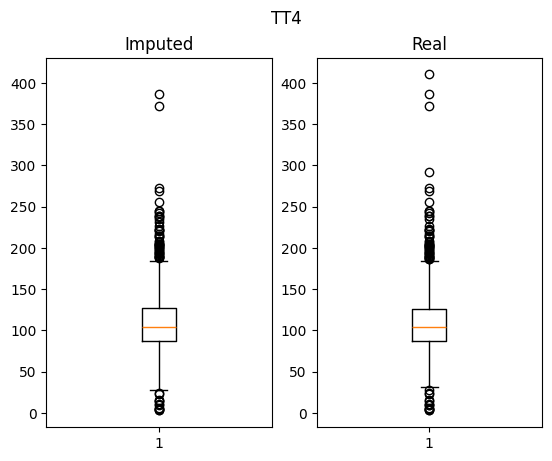

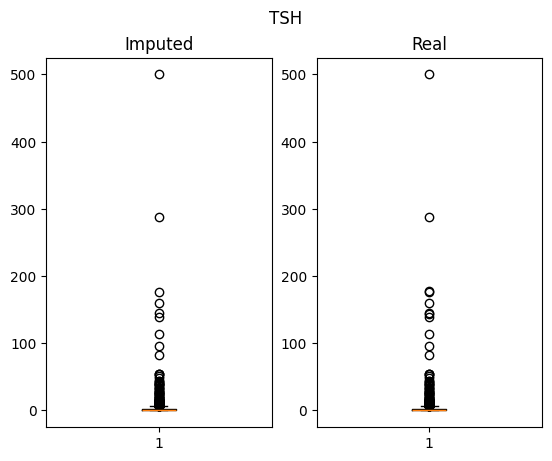

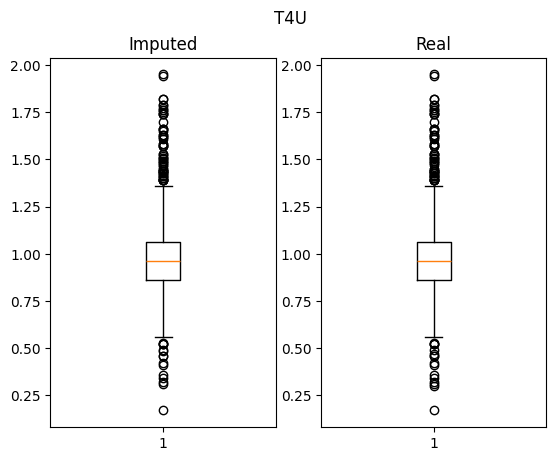

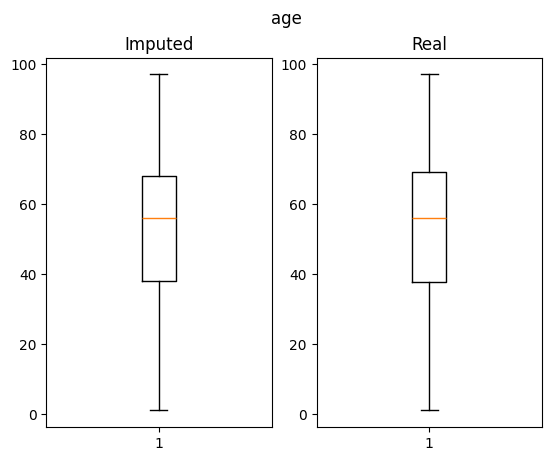

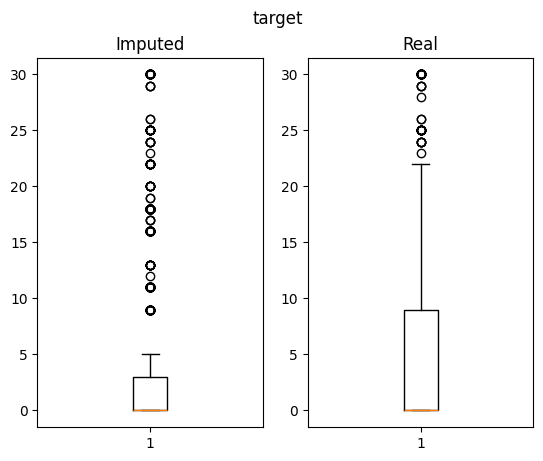

In [27]:
plot_col_boxplots(test_df[sel_qual_cols+['target']], imputed_test_df[sel_qual_cols+['target']])

## Imputation variant: fit-transform over train+test

In [28]:
missing_vals_df, missing_col_map, missing_vals_idxs = forget_random_col_per_sample(transformed_df, weight_map, random_generator)

In [29]:
all_imputer = MissForest(missing_values=np.NaN, n_estimators=100)
X_all = missing_vals_df.to_numpy()
X_all_imputed = all_imputer.fit_transform(X_all, cat_vars=get_column_indices(missing_vals_df, sel_cat_cols))

In [30]:
all_imputed_df = pd.DataFrame(X_all_imputed, columns=missing_vals_df.columns)
all_imputed_data_df = inverse_transform_categorical_columns(all_imputed_df.copy(), label_encoders)
all_imputed_data_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
0,f,f,f,f,f,f,f,f,f,f,-,F,85.0,2.4,90.0,1.50,1.06,36.0
1,f,f,f,f,f,f,f,f,f,f,-,F,96.0,2.3,104.0,1.20,1.08,40.0
2,f,f,f,f,f,f,f,f,f,f,-,F,105.0,2.1,88.0,5.90,0.84,40.0
3,f,f,f,f,f,f,f,f,f,f,-,F,95.0,2.4,107.0,0.05,1.13,77.0
4,f,f,f,f,f,f,f,f,f,f,-,F,106.0,2.1,93.0,0.05,0.87,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,f,f,f,f,f,f,f,f,f,f,-,M,94.0,1.8,85.0,0.73,0.90,65.0
5977,f,t,f,t,f,f,f,f,f,f,-,F,113.0,2.1,135.0,4.10,1.19,65.0
5978,t,f,f,f,f,f,f,f,f,f,F,F,39.0,1.0,49.0,53.00,1.25,74.0
5979,f,f,f,t,f,f,f,f,f,f,-,F,81.0,1.3,59.0,2.30,0.73,42.0


In [31]:
all_results = compare_imputations(transformed_df, all_imputed_df, missing_col_map)
all_results

,Column,MSE,RMSE,MAE
0,age,0.0,0.0,0.0
1,TSH,0.0,0.0,0.0
2,sex,0.0,0.0,0.0
3,on_thyroxine,0.0,0.0,0.0
4,target,0.0,0.0,0.0
5,FTI,0.0,0.0,0.0
6,tumor,0.0,0.0,0.0
7,sick,0.0,0.0,0.0
8,I131_treatment,0.0,0.0,0.0
9,on_antithyroid_meds,0.0,0.0,0.0


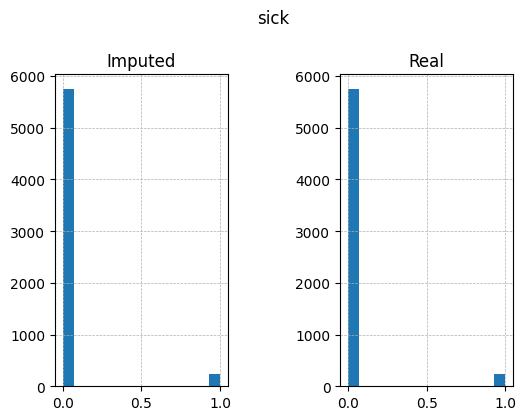

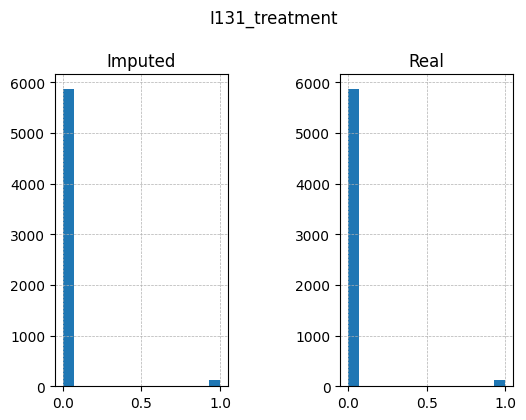

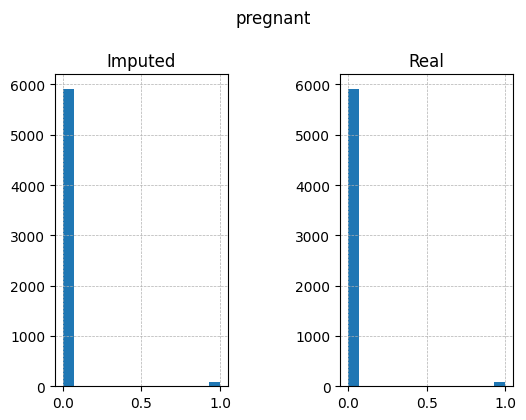

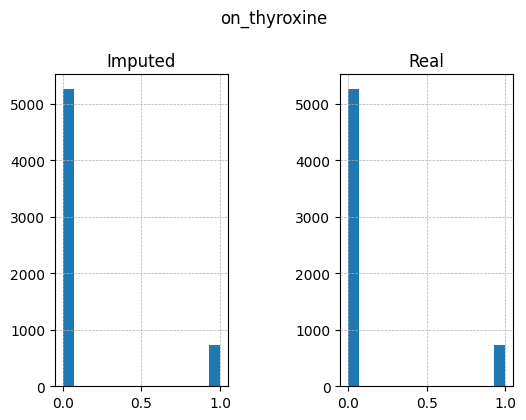

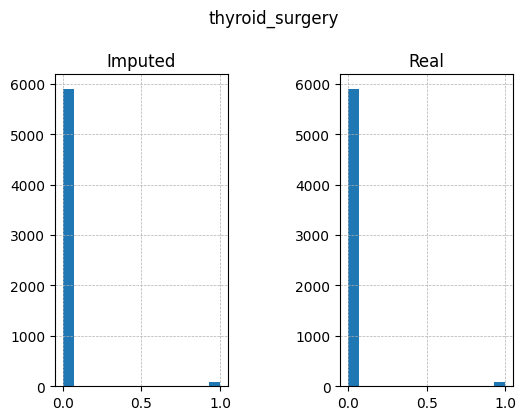

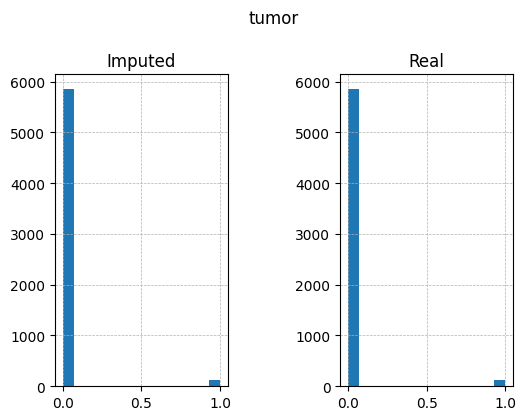

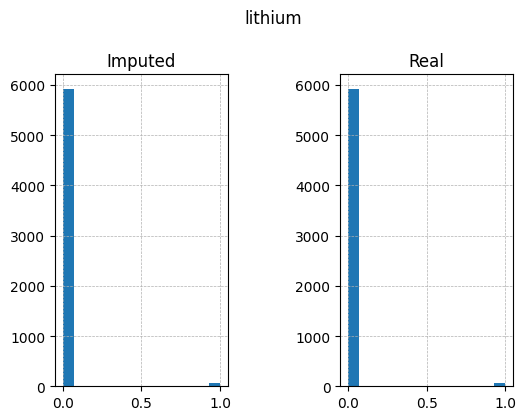

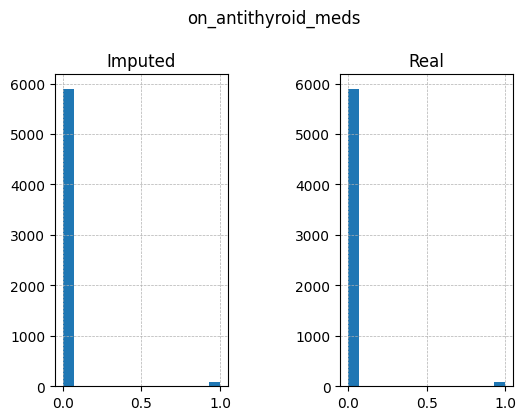

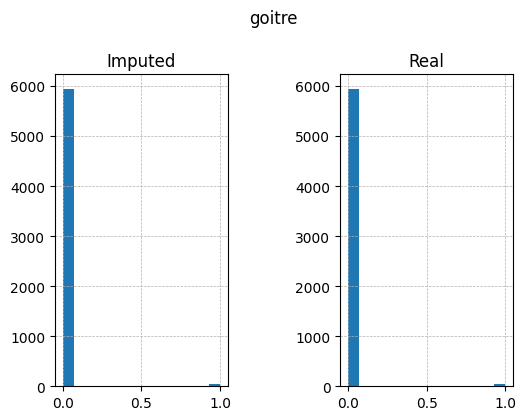

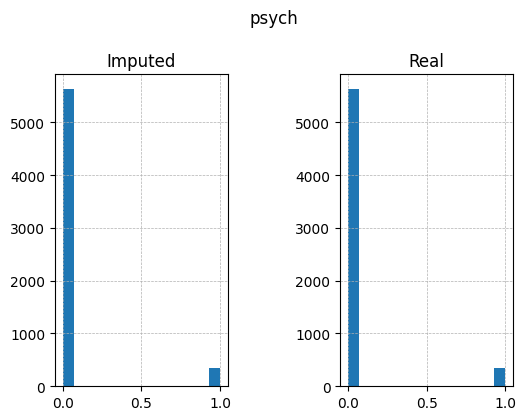

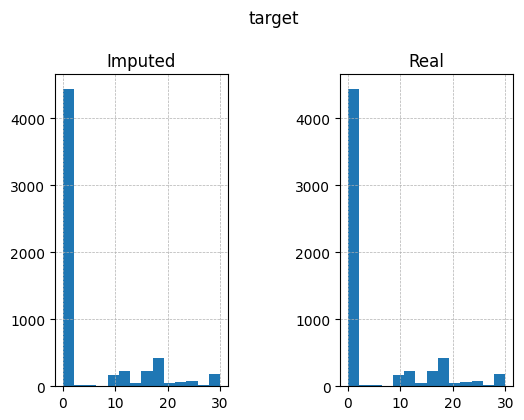

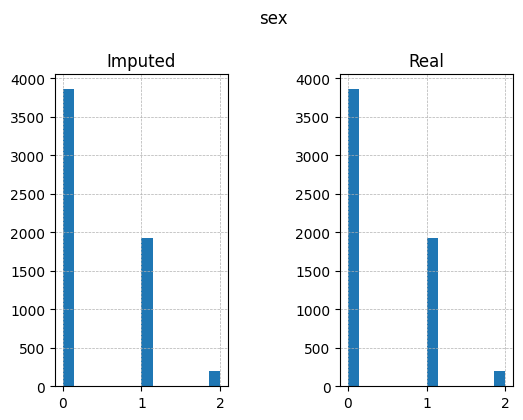

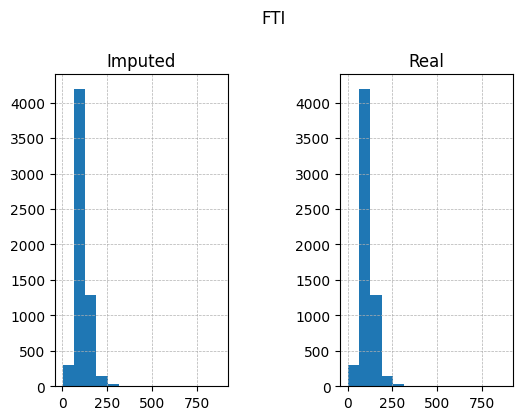

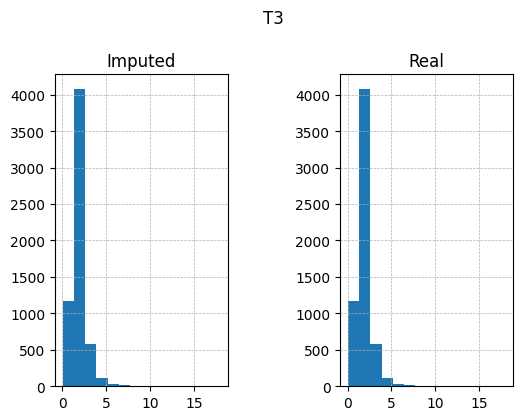

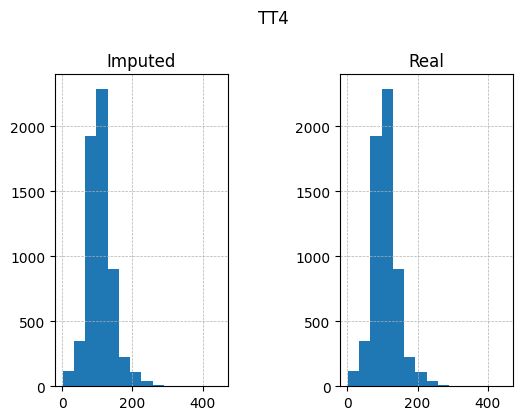

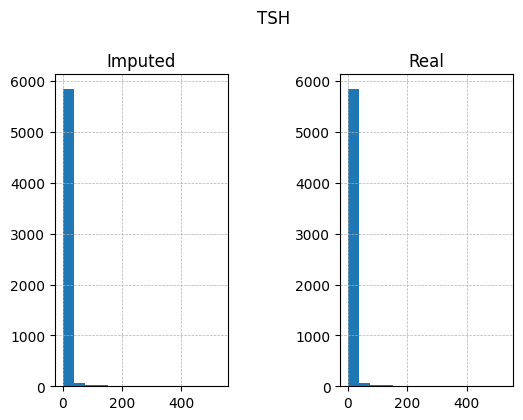

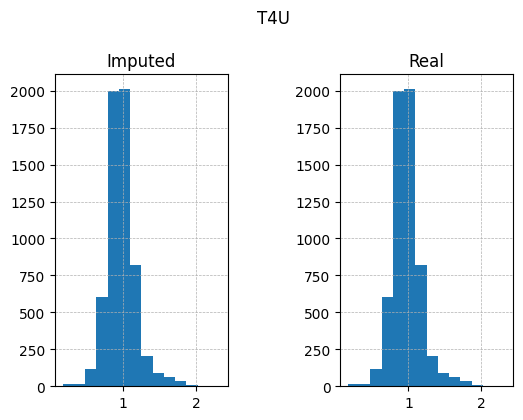

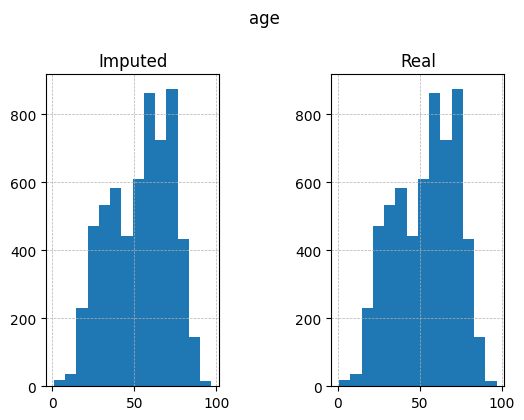

In [32]:
plot_col_histograms(transformed_df, all_imputed_df)

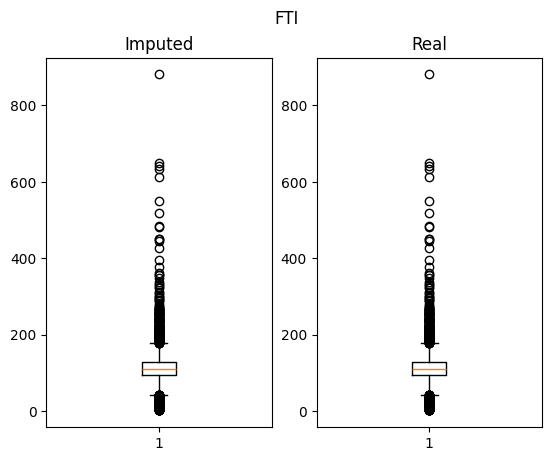

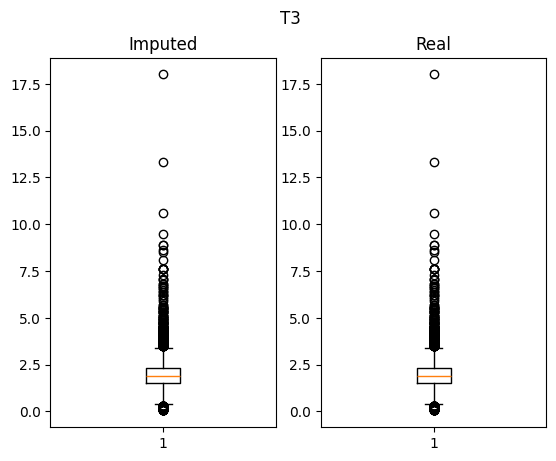

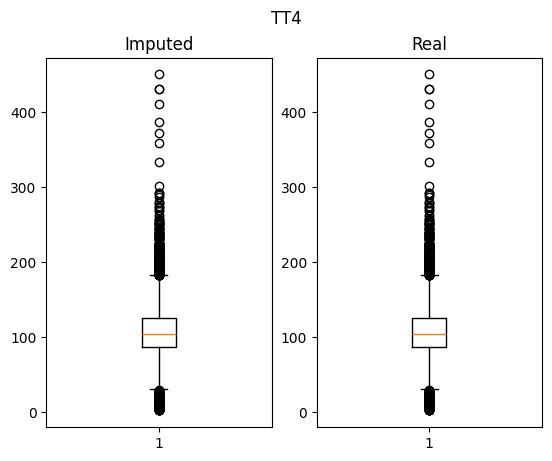

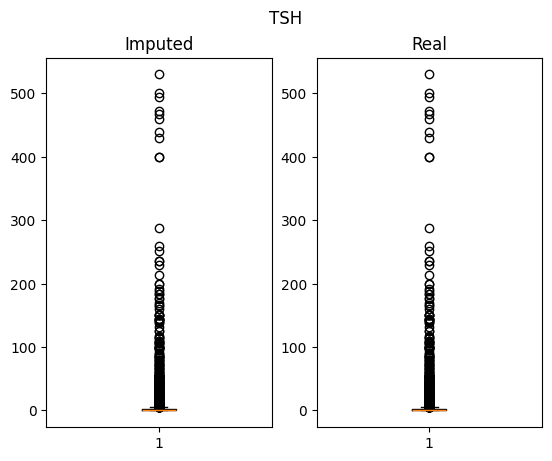

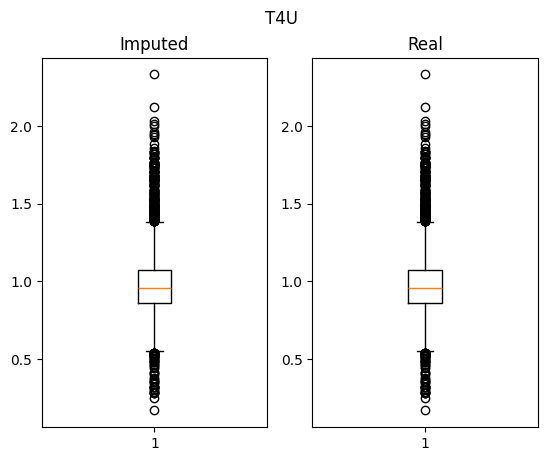

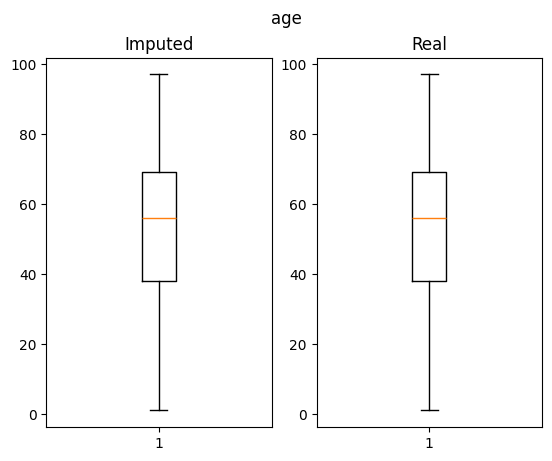

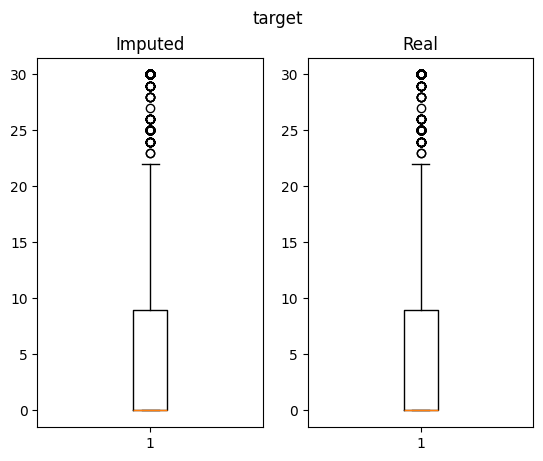

In [33]:
plot_col_boxplots(transformed_df[sel_qual_cols+['target']], all_imputed_df[sel_qual_cols+['target']])

In [34]:
all_imputed_means = np.concatenate([all_imputer.statistics_['col_modes'].flatten(), all_imputer.statistics_['col_means']])
all_imputed_means_df = pd.DataFrame([all_imputed_means], columns=sel_cat_cols+sel_qual_cols)
all_imputed_means_df = inverse_transform_categorical_columns(all_imputed_means_df, label_encoders)
all_imputed_means_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
0,f,f,f,f,f,f,f,f,f,f,-,F,113.087617,1.957079,108.081134,5.205002,0.974465,53.459121


### Impute initial df with missing values

In [35]:
X = transformed_nan_df.to_numpy()
X_imputed = all_imputer.transform(X)

Iteration: 0
Iteration: 1
Iteration: 2


In [36]:
imputed_df = pd.DataFrame(X_imputed, columns=transformed_nan_df.columns)
imputed_data_df = inverse_transform_categorical_columns(imputed_df.copy(), label_encoders)
imputed_data_df

,sick,I131_treatment,pregnant,on_thyroxine,thyroid_surgery,tumor,lithium,on_antithyroid_meds,goitre,psych,target,sex,FTI,T3,TT4,TSH,T4U,age
0,f,f,f,f,f,f,f,f,f,f,-,F,114.30,2.308,110.99,0.30000,0.9732,29.0
1,f,f,f,f,f,f,f,f,f,f,-,F,129.03,1.900,128.00,1.60000,0.9981,29.0
2,f,f,f,f,f,f,f,f,f,f,-,F,108.78,1.960,105.20,1.37850,0.9638,41.0
3,f,f,f,f,f,f,f,f,f,f,-,F,131.38,2.351,128.92,1.74170,0.9807,36.0
4,f,f,f,f,f,f,f,f,f,f,S,F,126.88,2.162,122.94,1.87095,0.9654,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,f,f,f,f,f,f,f,f,f,f,-,M,77.00,1.841,64.00,2.26420,0.8300,56.0
9164,f,f,f,f,f,f,f,f,f,f,-,M,99.00,2.185,91.00,1.59510,0.9200,22.0
9165,f,f,f,f,f,f,f,f,f,f,I,M,89.00,3.018,113.00,2.28485,1.2700,69.0
9166,f,f,f,f,f,f,f,f,f,f,-,F,88.00,1.689,75.00,1.40310,0.8500,47.0


## Imputation over data with noise

In [38]:
#from utils.noise_utils import add_noise

#noise_imputer = MissForest(missing_values=np.NaN, n_estimators=100)
#X_noise_train = train_missing_vals_df.to_numpy()
#noise_imputer = noise_imputer.fit(X_noise_train, cat_vars=get_column_indices(train_missing_vals_df, sel_cat_cols))
#X_noise_train_imputed = noise_imputer.transform(X_noise_train)